In [1]:
import pandas as pd

# The Cover Type Data Set

You can download it here:

https://archive.ics.uci.edu/ml/datasets/Covertype

In [3]:
# Column names for the data, c.f. the description for details.
# One important thing to note is that some of the variables
# (e.g. the soil type) are indicator variables. One could have
# a discussion about how sensible it is to use LDA with these,
# but we'll just proceed for educational value.
column_names = (
["Elevation",
"Aspect",
"Slope",
"Horizontal_Distance_To_Hydrology",
"Vertical_Distance_To_Hydrology",
"Horizontal_Distance_To_Roadways",
"Hillshade_9am",
"Hillshade_Noon",
"Hillshade_3pm",
"Horizontal_Distance_To_Fire_Points"]
    + ['WE{}'.format(i) for i in range(4)]
    + ['ST{}'.format(i) for i in range(40)]
    + ['Cover'])

In [6]:
cover_data = pd.read_csv('data/covtype.data.gz', names=column_names)

In [7]:
cover_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,ST31,ST32,ST33,ST34,ST35,ST36,ST37,ST38,ST39,Cover
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [8]:
%matplotlib inline

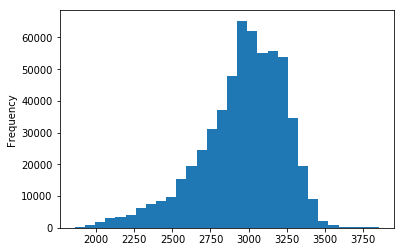

In [76]:
# Some variables look somewhat Gaussian, or
# at least like on could transform them to
# look somwhat Gaussian...
cover_data.Elevation.plot.hist(bins=30)

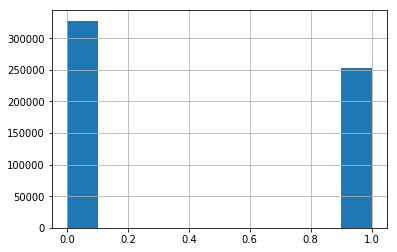

In [10]:
# ... while some clearly don't
cover_data.WE2.hist()

In [77]:
# Let's look at the priors to make sure that we
# don't have a singular, very small class.
cover_data.groupby('Cover').Cover.count() / cover_data.shape[0]

Cover
1    0.364605
2    0.487599
3    0.061537
4    0.004728
5    0.016339
6    0.029891
7    0.035300
Name: Cover, dtype: float64

In [12]:
import matplotlib.pyplot as plt

In [14]:
sample = cover_data.sample(10000)

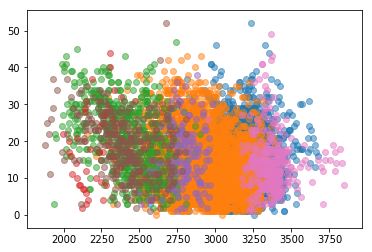

In [17]:
# plotting two examplary variables against each other
# shows that the classification task is a hard one
for k, group in sample.groupby('Cover'):
    plt.scatter(group.Elevation, group.Slope, alpha=0.5)

# Fitting Linear Discriminant Analysis

We now proceed to fit a LDA to our data.

$$\begin{align}
\hat \pi_l &= \frac{N_l}{N}\\
\hat \mu_l &= \frac 1 {N_l} \sum_{i, g_i = l} x_i\\
\hat \Sigma &= \frac 1 {N - K} \sum_l \sum_{i, g_i = l} (x_i - \hat \mu_l)(x_i -
  \hat \mu_l)^T\\
\hat \Sigma_l &= \frac 1 {N_l - 1} \sum_{i,g_i = l}(x_i - \hat \mu_l)(x_i -
  \hat \mu_l)^T
\end{align}$$

In [18]:
import numpy as np

In [19]:
from sklearn.model_selection import train_test_split

In [67]:
train, test = train_test_split(cover_data, test_size=0.3)

In [21]:
# Sanity check: Make sure we have all the classes
# in the training data set ...
train.groupby('Cover').Cover.count()

Cover
1    148028
2    198472
3     25023
4      1900
5      6668
6     12212
7     14405
Name: Cover, dtype: int64

In [78]:
# ... and in the test data set as well...
test.groupby('Cover').Cover.count()

Cover
1    63479
2    85204
3    10592
4      847
5     2840
6     5109
7     6233
Name: Cover, dtype: int64

In [79]:
means, pis, labels, Sigmas = [], [], [], []
N, p = train.shape
p -= 1
Sigma = np.zeros([p, p])
for label, data in train.groupby('Cover'):
    labels.append(label)
    Nk, _ = data.shape
    # prior
    pi = Nk / float(N)
    pis.append(pi)
    # mean
    mu = data.mean()
    # below, XXX[:-1]: Drop the 'Cover' column
    means.append(mu[:-1])
    xn = (data - mu).values[:,:-1]
    # Sigma_k
    S = np.zeros([p, p])
    for i in range(Nk):
        S += np.dot(xn[i:i+1,:].T, xn[i:i+1,:])
    Sigmas.append(S / (Nk - 1))
    # total Sigma
    Sigma += S
# normalize Sigma
Sigma /= float(N - len(labels))

In [80]:
# Don't try this at home.
# It's usually a bad idea to invert a matrix!
# Recommended reading: https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/
Sigmainv = np.linalg.inv(Sigma)

In [32]:
pis

[0.36396628539394354,
 0.487996302015205,
 0.061525713779910896,
 0.004671656323455649,
 0.016395054928843297,
 0.030026456327389674,
 0.0354185312312519]

In [70]:
# Discriminant functions
def delta(x, mu, pi):
    return (np.dot(np.dot(x, Sigmainv), mu)
            - 0.5 * np.dot(np.dot(mu.T, Sigmainv), mu)
            + np.log(pi))

In [71]:
# calssifer
def lda(x):
    return np.argmax(np.array([delta(x, mu, pi) for mu, pi in zip(means, pis)]).T, axis=1)
# Note that lda classifies 0, ..., K-1 ...

In [72]:
# ... but our labels are 1, ..., K
labels

[1, 2, 3, 4, 5, 6, 7]

In [73]:
# So we need to add 1 to make a prediciton
# Let's calcuate the hit rate:
# HR = (true positives + true negatives) / N
# Note we need column_names[:-1] to drop the 'Cover' column
((lda(test[column_names[:-1]]) + 1) == test.Cover).mean()

0.68051220855516803

In [81]:
# per-class hit rate:
for k, data in test.groupby('Cover'):
    print k, (lda(data[column_names[:-1]]) + 1 == data.Cover).mean()

1 0.618046913152
2 0.761137974743
3 0.533232628399
4 0.611570247934
5 0.223943661972
6 0.525543159131
7 0.810364190598
